In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from pysal.lib import weights
from libpysal.io import open as psopen
# import plots
import seaborn as sns
from datetime import datetime, timedelta
import jenkspy

In [2]:
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/Research/RECAST/latin-mobility-covid-local-files'


country = 'Colombia'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
elif country == 'Mexico':
    country_short = 'MEX'
    country_code = 'MX'

In [3]:
popcell_baseline_imput_pop = gpd.read_file(wd + '/data/outputs/' + country_short + '/grids-with-data/popcell-baseline-imput-pop/popcell-baseline-imput-pop.gpkg')
movcell_baseline_imput_pop = gpd.read_file(wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop/movcell-baseline-imput-pop.gpkg')
baseline_mov_imput = pd.read_csv(wd + '/data/outputs/' + country_short + '/baseline/movcell-baseline-imput-mov-dist-with-exo-var-flatten.csv').drop('Unnamed: 0', axis=1)


In [4]:
grid_popcell = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_FB_pop/Grid_' + country + '.shp').to_crs('EPSG:4326')
grid_movcell = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_FB_mov/Grid_' + country + '.shp').to_crs('EPSG:4326')
grid_lookup = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_lookup_mov_to_pop.gpkg').to_crs('EPSG:4326')


In [5]:
popcell_baseline_imput_pop

,0,1,2,3,4,5,6,pop_wp,geometry
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-69.96094 -4.21494, -69.96094 -4.216..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-69.96094 -4.21494, -69.92853 -4.214..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.369087,"POLYGON ((-70.00488 -4.17112, -70.00488 -4.191..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949.861694,"POLYGON ((-70.00488 -4.17112, -69.96094 -4.171..."
4,976.637078,981.820558,969.339036,972.437329,959.101578,941.713506,927.32902,17733.955078,"POLYGON ((-69.96094 -4.21494, -69.96094 -4.171..."
...,...,...,...,...,...,...,...,...,...
49319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-79.73437 15.86627, -79.73682 15.863..."
49320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-78.68076 15.83453, -78.68048 ..."
49321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-78.63568 15.85669, -78.63818 15.854..."
49322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-79.72082 15.89630, -79.71942 15.897..."


In [6]:
directory = wd + '/data/outputs/' + country_short + '/pop'
files = sorted(os.listdir(directory))
files = [file for file in files if not file.startswith('.')]

start_date = datetime.strptime(files[0][-19:-9], '%Y-%m-%d')
end_date = datetime.strptime(files[-1][-19:-9], '%Y-%m-%d')
delta = end_date - start_date
columns = [str(start_date + timedelta(days=i))[0:10] for i in range(delta.days + 1)] 

df_pop_evo_popcell = pd.DataFrame({column: [np.nan for i in range(len(popcell_baseline_imput_pop))] for column in columns})

df_pop_evo_popcell.insert(loc=df_pop_evo_popcell.columns.get_loc(df_pop_evo_popcell.columns[0]), column='FID', value=popcell_baseline_imput_pop.index)


In [7]:
for i in range(len(files)):
    
    if i%20 == 0:
        print(i/len(files)*100)
        
    file = files[i]

    df_pops = pd.read_csv(directory + '/' + file).drop('Unnamed: 0', axis=1)

    date = file[-19:-9]
    wday = datetime.strptime(file[-19:-9], "%Y-%m-%d").weekday()

    for j in range(len(df_pops)):
        FID_popcell = df_pops.loc[j, 'FID']
        # FID_movcell = grid_lookup[grid_lookup['FID_pop']==FID_popcell].reset_index(drop=True).loc[0, 'FID_mov']

        n_crisis = df_pops.loc[j, 'n_crisis']

        if pd.isna(n_crisis) == False:
            df_pop_evo_popcell.loc[np.where(df_pop_evo_popcell['FID']==FID_popcell)[0], str(date)] = n_crisis
        else:
            per_change = df_pops.loc[j, 'percent_change']
            n_baseline = popcell_baseline_imput_pop.loc[np.where(df_pop_evo_popcell['FID']==FID_popcell)[0], str(wday)]
            df_pop_evo_popcell.loc[np.where(df_pop_evo_popcell['FID']==FID_popcell)[0], str(date)] = n_baseline*per_change/100 + n_baseline
            
df_pop_evo_popcell.to_csv(wd + '/data/outputs/' + country_short + '/evo/pop_evo_popcell.csv')

0.0
2.5773195876288657
5.154639175257731
7.731958762886598
10.309278350515463
12.886597938144329
15.463917525773196
18.04123711340206
20.618556701030926
23.195876288659793
25.773195876288657
28.350515463917525
30.927835051546392
33.50515463917525
36.08247422680412
38.659793814432994
41.23711340206185
43.81443298969072
46.391752577319586
48.96907216494845
51.546391752577314
54.123711340206185
56.70103092783505
59.27835051546392
61.855670103092784
64.43298969072166
67.0103092783505
69.58762886597938
72.16494845360825
74.74226804123711
77.31958762886599
79.89690721649485
82.4742268041237
85.05154639175258
87.62886597938144
90.20618556701031
92.78350515463917
95.36082474226805
97.9381443298969


In [8]:
df_pop_evo_popcell = pd.read_csv(wd + '/data/outputs/' + country_short + '/evo/pop_evo_popcell.csv').drop('Unnamed: 0', axis=1)



In [9]:
df_pop_evo_popcell

,FID,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,...,2022-05-12,2022-05-13,2022-05-14,2022-05-15,2022-05-16,2022-05-17,2022-05-18,2022-05-19,2022-05-20,2022-05-21
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,826.181029,918.31276,971.235338,969.294625,960.531964,954.492829,955.831308,957.140604,930.153442,...,744.734083,736.831349,717.044034,698.628056,724.872958,756.488551,753.545917,442.010032,454.756673,700.138146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49319,49319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49320,49320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49321,49321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49322,49322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
gdf_lookup = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_lookup_mov_to_pop.gpkg') 

In [11]:
df_pop_evo_movcell = pd.DataFrame({column: [np.nan for i in range(len(movcell_baseline_imput_pop))] for column in columns})

df_pop_evo_movcell.insert(loc=df_pop_evo_movcell.columns.get_loc(df_pop_evo_movcell.columns[0]), column='FID', value=movcell_baseline_imput_pop.index)


In [12]:
for i in range(len(df_pop_evo_movcell)):
    if i%500 == 0:
        print(i/len(df_pop_evo_movcell)*100)
    FIDs_pop = np.array(gdf_lookup[gdf_lookup['FID_mov']==i]['FID_pop'])
    for j in range(1, len(df_pop_evo_movcell.columns)):
        pops = np.array(df_pop_evo_popcell.iloc[FIDs_pop][df_pop_evo_popcell.columns[j]])
        pops = pops[~np.isnan(pops)]
        if len(pops)>0:
            df_pop_evo_movcell.loc[i, df_pop_evo_movcell.columns[j]] = np.sum(pops)
        else:
            df_pop_evo_movcell.loc[i, df_pop_evo_movcell.columns[j]] = np.nan    
            
df_pop_evo_movcell.to_csv(wd + '/data/outputs/' + country_short + '/evo/pop_evo_movcell.csv')

0.0
1.013705295596464
2.027410591192928
3.0411158867893926
4.054821182385856
5.068526477982321
6.082231773578785
7.09593706917525
8.109642364771712
9.123347660368179
10.137052955964641
11.150758251561106
12.16446354715757
13.178168842754035
14.1918741383505
15.205579433946964
16.219284729543425
17.23299002513989
18.246695320736357
19.26040061633282
20.274105911929283
21.28781120752575
22.301516503122212
23.315221798718678
24.32892709431514
25.342632389911607
26.35633768550807
27.370042981104532
28.383748276701
29.39745357229746
30.411158867893928
31.42486416349039
32.43856945908685
33.45227475468332
34.46598005027978
35.47968534587625
36.493390641472715
37.507095937069174
38.52080123266564
39.534506528262106
40.548211823858566
41.56191711945503
42.5756224150515
43.589327710647964
44.603033006244424
45.61673830184089
46.630443597437356
47.644148893033815
48.65785418863028
49.67155948422675
50.685264779823214
51.69897007541967
52.71267537101614
53.726380666612606
54.740085962209065
55.75

In [13]:
df_pop_evo_movcell = pd.read_csv(wd + '/data/outputs/' + country_short + '/evo/pop_evo_movcell.csv').drop('Unnamed: 0', axis=1)


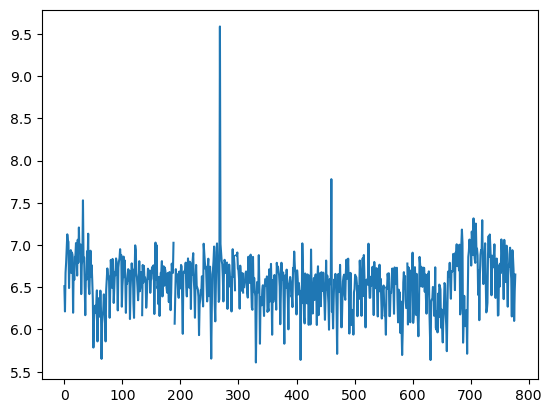

In [17]:
plt.plot(np.arange(len(df_pop_evo_movcell.columns[1:])), df_pop_evo_movcell.loc[450, df_pop_evo_movcell.columns[1:]])
